# Unit14_Model_Selection_Pipeline | 完整模型選擇流程

本 Notebook 展示從資料前處理到最終模型部署的完整 Pipeline 建立流程，使用 `Part_3/Unit14/data/reactor_simulation/` 中的反應器模擬數據，建立程序品質預測系統。

## 目標
- 學習使用 sklearn Pipeline 整合前處理與建模
- 學習使用 ColumnTransformer 處理不同類型特徵
- 建立多模型自動化訓練與評估框架
- 實作模型持久化：儲存與載入最佳模型
- 完成化工程序品質預測系統的端到端建模流程

## 資料背景
反應器操作數據包含：
- **數值特徵**：溫度、壓力、流量、濃度等連續變數
- **類別特徵**：催化劑類型、操作模式等離散變數
- **目標變數**：產品收率 (Yield, %)

本案例展示如何建立可重複使用的模型選擇 Pipeline，適用於實際工業應用場景。

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit14_Model_Selection_Pipeline'
SOURCE_DATA_DIR = 'reactor_simulation'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit14'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\data\reactor_simulation
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Selection_Pipeline
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Selection_Pipeline\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Selection_Pipeline\figs


In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

# sklearn 資料處理套件
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# sklearn 模型套件
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# sklearn 評估指標
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

print("✓ 所有套件載入完成")

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)

# 設定matplotlib中文顯示
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

print(f"✓ 隨機種子設定: {SEED}")

✓ 所有套件載入完成
✓ 隨機種子設定: 42


---
## 1. 生成模擬資料

生成反應器操作數據，包含數值特徵與類別特徵：
- **數值特徵**：Temperature, Pressure, Flow_Rate, Concentration, Residence_Time
- **類別特徵**：Catalyst_Type, Operation_Mode
- **目標變數**：Yield (%)

In [ ]:
# 生成模擬反應器操作數據
np.random.seed(SEED)
n_samples = 500

# 數值特徵生成
data = {
    'Temperature': np.random.uniform(150, 250, n_samples),  # °C
    'Pressure': np.random.uniform(1, 10, n_samples),        # bar
    'Flow_Rate': np.random.uniform(10, 100, n_samples),     # L/min
    'Concentration': np.random.uniform(0.1, 5.0, n_samples), # mol/L
    'Residence_Time': np.random.uniform(5, 60, n_samples),  # min
}

# 類別特徵生成
data['Catalyst_Type'] = np.random.choice(['Type_A', 'Type_B', 'Type_C'], n_samples)
data['Operation_Mode'] = np.random.choice(['Continuous', 'Batch', 'Semi-Batch'], n_samples)

# 建立DataFrame
df = pd.DataFrame(data)

# 生成目標變數：Yield (%) - 基於複雜的非線性關係
# Yield 受到溫度、壓力、催化劑類型等多重因素影響
catalyst_effect = df['Catalyst_Type'].map({'Type_A': 8, 'Type_B': 5, 'Type_C': 2})
mode_effect = df['Operation_Mode'].map({'Continuous': 3, 'Batch': 0, 'Semi-Batch': 1.5})

df['Yield'] = (
    30 +  # 基礎產率
    0.15 * df['Temperature'] +  # 溫度正效應
    1.5 * df['Pressure'] +     # 壓力正效應
    0.08 * df['Flow_Rate'] +    # 流量效應
    2.5 * df['Concentration'] + # 濃度正效應
    -0.12 * df['Residence_Time'] + # 滯留時間負效應
    catalyst_effect +  # 催化劑效應
    mode_effect +      # 操作模式效應
    -0.004 * (df['Temperature'] - 200)**2 +  # 溫度二次效應
    np.random.normal(0, 3, n_samples)  # 隨機雜訊
)

# 限制 Yield 在合理範圍內 (0-100%)
df['Yield'] = df['Yield'].clip(0, 100)

# 儲存數據
DATA_DIR.mkdir(parents=True, exist_ok=True)
data_file = DATA_DIR / 'reactor_data.csv'
df.to_csv(data_file, index=False)

print(f"✓ 生成 {n_samples} 筆反應器操作數據")
print(f"✓ 數據已儲存至: {data_file}")
print(f"\n數據集形狀: {df.shape}")
print(f"\n前5筆數據:")
df.head()

✓ 生成 500 筆反應器操作數據
✓ 數據已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\data\reactor_simulation\reactor_data.csv

數據集形狀: (500, 8)

前5筆數據:


,Temperature,Pressure,Flow_Rate,Concentration,Residence_Time,Catalyst_Type,Operation_Mode,Yield
0,187.454012,7.283455,26.661964,2.643501,19.393813,Type_C,Continuous,79.786616
1,245.071431,5.824867,58.771085,2.447991,18.583834,Type_C,Semi-Batch,77.394702
2,223.199394,3.785749,88.565125,0.225646,54.844002,Type_C,Continuous,71.594361
3,209.865848,8.324155,75.900240,1.772114,18.725041,Type_C,Semi-Batch,89.662966
4,165.601864,7.162581,82.590503,1.962959,19.957235,Type_C,Continuous,71.201471


---
## 2. 資料探索分析 (EDA)

檢視數據基本統計資訊與特徵分佈

In [4]:
# 基本資訊
print("=" * 60)
print("Dataset Information")
print("=" * 60)
print(f"Total samples: {len(df)}")
print(f"Features: {df.shape[1] - 1} (5 numerical + 2 categorical)")
print(f"Target: Yield\n")

# 數值特徵統計
print("Numerical Features Statistics:")
print(df.describe().round(2))

# 類別特徵分佈
print("\n" + "=" * 60)
print("Categorical Features Distribution:")
print("=" * 60)
print("\nCatalyst_Type:")
print(df['Catalyst_Type'].value_counts())
print("\nOperation_Mode:")
print(df['Operation_Mode'].value_counts())

# 目標變數統計
print("\n" + "=" * 60)
print("Target Variable (Yield) Statistics:")
print("=" * 60)
print(f"Mean: {df['Yield'].mean():.2f}%")
print(f"Std: {df['Yield'].std():.2f}%")
print(f"Min: {df['Yield'].min():.2f}%")
print(f"Max: {df['Yield'].max():.2f}%")

Dataset Information
Total samples: 500
Features: 7 (5 numerical + 2 categorical)
Target: Yield

Numerical Features Statistics:
       Temperature  Pressure  Flow_Rate  Concentration  Residence_Time   Yield
count       500.00    500.00     500.00         500.00          500.00  500.00
mean        199.86      5.34      56.58           2.53           32.49   78.08
std          29.87      2.57      26.75           1.41           15.72    9.08
min         150.51      1.04      10.44           0.12            5.09   49.74
25%         174.13      3.06      31.71           1.28           19.75   71.92
50%         201.32      5.25      58.58           2.59           32.28   78.65
75%         225.61      7.54      79.96           3.71           45.88   84.36
max         249.30     10.00      99.95           4.99           59.75   98.70

Categorical Features Distribution:

Catalyst_Type:
Catalyst_Type
Type_A    174
Type_B    165
Type_C    161
Name: count, dtype: int64

Operation_Mode:
Operation_M

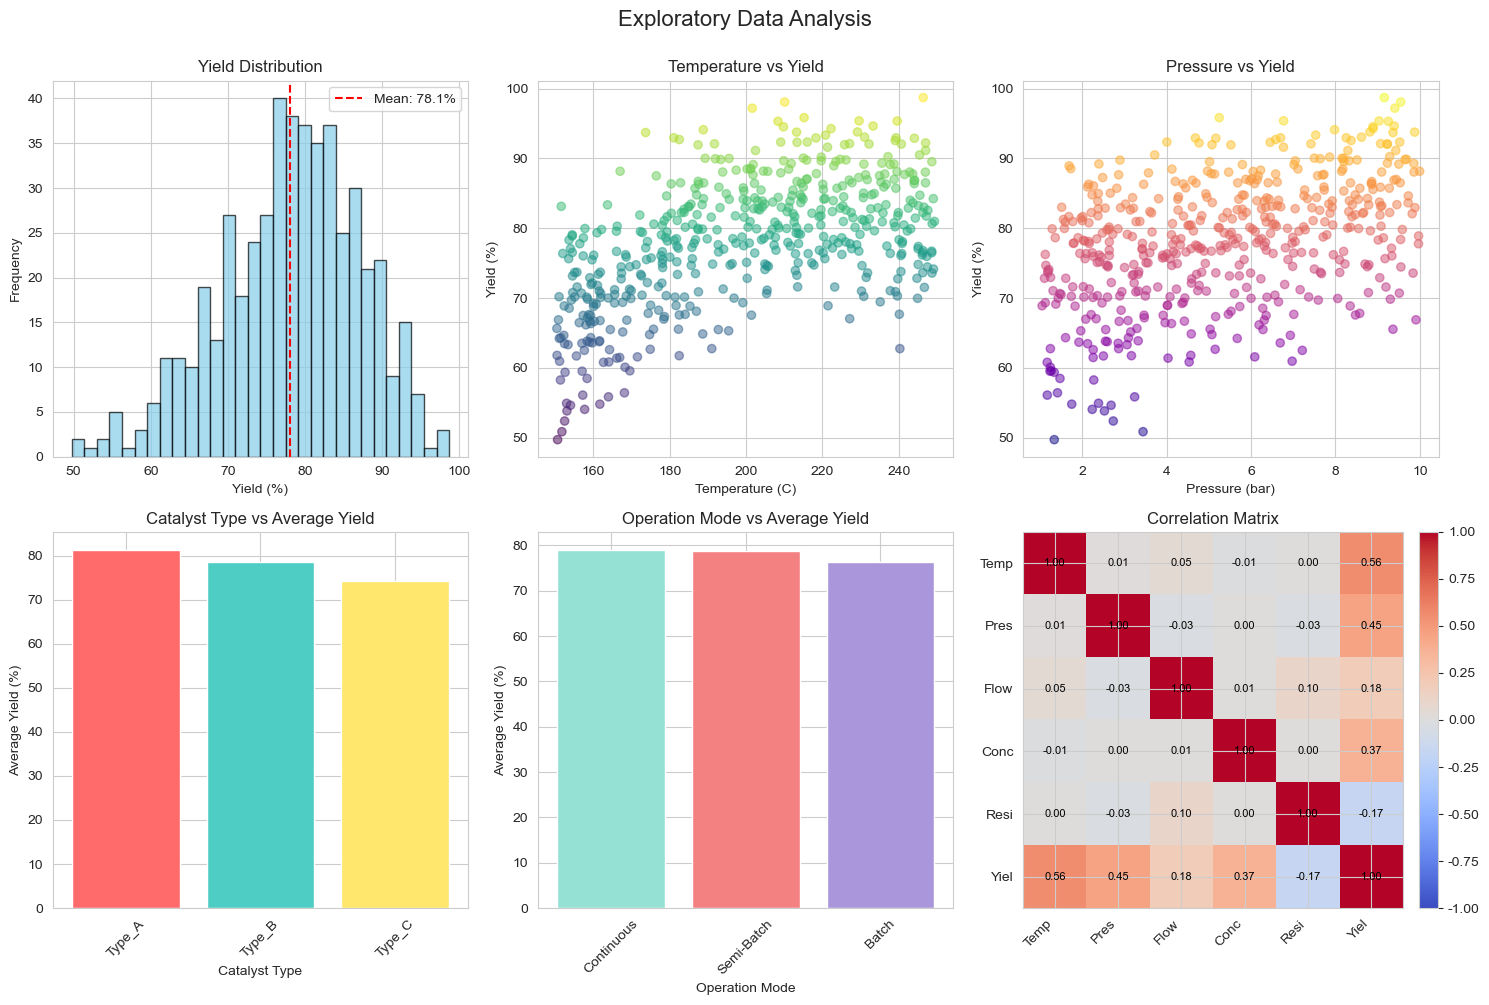

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Selection_Pipeline\figs\eda_analysis.png


In [5]:
# 視覺化分析
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Exploratory Data Analysis', fontsize=16, y=1.00)

# 1. Yield分佈
axes[0, 0].hist(df['Yield'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Yield (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Yield Distribution')
axes[0, 0].axvline(df['Yield'].mean(), color='red', linestyle='--', label=f'Mean: {df["Yield"].mean():.1f}%')
axes[0, 0].legend()

# 2. Temperature vs Yield
axes[0, 1].scatter(df['Temperature'], df['Yield'], alpha=0.5, c=df['Yield'], cmap='viridis')
axes[0, 1].set_xlabel('Temperature (C)')
axes[0, 1].set_ylabel('Yield (%)')
axes[0, 1].set_title('Temperature vs Yield')

# 3. Pressure vs Yield
axes[0, 2].scatter(df['Pressure'], df['Yield'], alpha=0.5, c=df['Yield'], cmap='plasma')
axes[0, 2].set_xlabel('Pressure (bar)')
axes[0, 2].set_ylabel('Yield (%)')
axes[0, 2].set_title('Pressure vs Yield')

# 4. Catalyst_Type vs Yield
catalyst_yield = df.groupby('Catalyst_Type')['Yield'].mean().sort_values(ascending=False)
axes[1, 0].bar(catalyst_yield.index, catalyst_yield.values, color=['#FF6B6B', '#4ECDC4', '#FFE66D'])
axes[1, 0].set_xlabel('Catalyst Type')
axes[1, 0].set_ylabel('Average Yield (%)')
axes[1, 0].set_title('Catalyst Type vs Average Yield')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Operation_Mode vs Yield
mode_yield = df.groupby('Operation_Mode')['Yield'].mean().sort_values(ascending=False)
axes[1, 1].bar(mode_yield.index, mode_yield.values, color=['#95E1D3', '#F38181', '#AA96DA'])
axes[1, 1].set_xlabel('Operation Mode')
axes[1, 1].set_ylabel('Average Yield (%)')
axes[1, 1].set_title('Operation Mode vs Average Yield')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Correlation Heatmap (數值特徵)
numerical_cols = ['Temperature', 'Pressure', 'Flow_Rate', 'Concentration', 'Residence_Time', 'Yield']
corr_matrix = df[numerical_cols].corr()
im = axes[1, 2].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
axes[1, 2].set_xticks(range(len(numerical_cols)))
axes[1, 2].set_yticks(range(len(numerical_cols)))
axes[1, 2].set_xticklabels([col[:4] for col in numerical_cols], rotation=45, ha='right')
axes[1, 2].set_yticklabels([col[:4] for col in numerical_cols])
axes[1, 2].set_title('Correlation Matrix')

# 添加相關係數數值
for i in range(len(numerical_cols)):
    for j in range(len(numerical_cols)):
        text = axes[1, 2].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                               ha="center", va="center", color="black", fontsize=8)

plt.colorbar(im, ax=axes[1, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(FIG_DIR / 'eda_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存至: {FIG_DIR / 'eda_analysis.png'}")

---
## 3. 建立資料前處理 Pipeline

使用 `ColumnTransformer` 整合不同類型特徵的前處理：
- **數值特徵**：StandardScaler 標準化
- **類別特徵**：OneHotEncoder 編碼

In [6]:
# 定義特徵與目標
numerical_features = ['Temperature', 'Pressure', 'Flow_Rate', 'Concentration', 'Residence_Time']
categorical_features = ['Catalyst_Type', 'Operation_Mode']

X = df[numerical_features + categorical_features]
y = df['Yield']

# 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

print(f"✓ 訓練集樣本數: {X_train.shape[0]}")
print(f"✓ 測試集樣本數: {X_test.shape[0]}")
print(f"\n特徵資訊:")
print(f"  - 數值特徵 ({len(numerical_features)}): {numerical_features}")
print(f"  - 類別特徵 ({len(categorical_features)}): {categorical_features}")

✓ 訓練集樣本數: 400
✓ 測試集樣本數: 100

特徵資訊:
  - 數值特徵 (5): ['Temperature', 'Pressure', 'Flow_Rate', 'Concentration', 'Residence_Time']
  - 類別特徵 (2): ['Catalyst_Type', 'Operation_Mode']


In [7]:
# 建立前處理 Pipeline
# 數值特徵：標準化
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 類別特徵：One-Hot 編碼
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# 使用 ColumnTransformer 整合
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # 保留未指定的欄位
)

print("✓ 前處理 Pipeline 建立完成")
print("\nPipeline 結構:")
print(preprocessor)

✓ 前處理 Pipeline 建立完成

Pipeline 結構:
ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Temperature', 'Pressure', 'Flow_Rate',
                                  'Concentration', 'Residence_Time']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['Catalyst_Type', 'Operation_Mode'])])


---
## 4. 建立多模型 Pipeline

整合前處理與模型訓練的完整 Pipeline，包含多種回歸模型：
- Linear Models: Linear Regression, Ridge, Lasso, ElasticNet
- Tree-based Models: Decision Tree, Random Forest, Gradient Boosting
- Other Models: SVR
- Advanced Boosting: XGBoost, LightGBM, CatBoost

In [8]:
# 定義多個候選模型
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=SEED),
    'Lasso': Lasso(alpha=0.1, random_state=SEED),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=SEED),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=SEED),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=SEED, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=SEED),
    'SVR': SVR(kernel='rbf', C=10, gamma='scale'),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=SEED, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=SEED, n_jobs=-1, verbose=-1),
    'CatBoost': CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1, random_state=SEED, verbose=0)
}

# 為每個模型建立完整的 Pipeline (前處理 + 模型)
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

print(f"✓ 建立 {len(pipelines)} 個模型 Pipeline")
print("\n模型清單:")
for i, name in enumerate(pipelines.keys(), 1):
    print(f"  {i}. {name}")

✓ 建立 11 個模型 Pipeline

模型清單:
  1. Linear Regression
  2. Ridge
  3. Lasso
  4. ElasticNet
  5. Decision Tree
  6. Random Forest
  7. Gradient Boosting
  8. SVR
  9. XGBoost
  10. LightGBM
  11. CatBoost


---
## 5. 自動化模型訓練與評估

使用 Cross-Validation 評估所有模型性能

In [9]:
# 定義評估函數
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, cv=5):
    """
    評估模型性能
    
    Parameters:
    -----------
    pipeline : sklearn.pipeline.Pipeline
        包含前處理與模型的完整 Pipeline
    X_train, y_train : 訓練資料
    X_test, y_test : 測試資料
    cv : int, 交叉驗證折數
    
    Returns:
    --------
    results : dict, 包含各項評估指標
    """
    # 訓練模型
    start_time = datetime.datetime.now()
    pipeline.fit(X_train, y_train)
    training_time = (datetime.datetime.now() - start_time).total_seconds()
    
    # 交叉驗證
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, 
                                 scoring='r2', n_jobs=-1)
    
    # 預測
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # 計算評估指標
    results = {
        'Training Time (s)': training_time,
        'CV R² (mean)': cv_scores.mean(),
        'CV R² (std)': cv_scores.std(),
        'Train R²': r2_score(y_train, y_train_pred),
        'Test R²': r2_score(y_test, y_test_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'Test MAPE': mean_absolute_percentage_error(y_test, y_test_pred)
    }
    
    return results, y_test_pred

print("✓ 評估函數定義完成")

✓ 評估函數定義完成


In [10]:
# 執行所有模型的訓練與評估
print("開始訓練與評估所有模型...")
print("=" * 80)

all_results = {}
predictions = {}

for name, pipeline in pipelines.items():
    print(f"\n訓練模型: {name}")
    print("-" * 80)
    
    try:
        results, y_pred = evaluate_model(pipeline, X_train, y_train, X_test, y_test)
        all_results[name] = results
        predictions[name] = y_pred
        
        print(f"✓ 訓練完成 - 耗時: {results['Training Time (s)']:.2f}s")
        print(f"  CV R²: {results['CV R² (mean)']:.4f} (+/- {results['CV R² (std)']:.4f})")
        print(f"  Test R²: {results['Test R²']:.4f}")
        print(f"  Test RMSE: {results['Test RMSE']:.4f}")
        
    except Exception as e:
        print(f"✗ 訓練失敗: {str(e)}")
        all_results[name] = None

print("\n" + "=" * 80)
print("✓ 所有模型訓練與評估完成")

開始訓練與評估所有模型...

訓練模型: Linear Regression
--------------------------------------------------------------------------------
✓ 訓練完成 - 耗時: 0.02s
  CV R²: 0.7643 (+/- 0.0301)
  Test R²: 0.7948
  Test RMSE: 4.1067

訓練模型: Ridge
--------------------------------------------------------------------------------
✓ 訓練完成 - 耗時: 0.01s
  CV R²: 0.7644 (+/- 0.0295)
  Test R²: 0.7945
  Test RMSE: 4.1091

訓練模型: Lasso
--------------------------------------------------------------------------------
✓ 訓練完成 - 耗時: 0.01s
  CV R²: 0.7593 (+/- 0.0268)
  Test R²: 0.7873
  Test RMSE: 4.1811

訓練模型: ElasticNet
--------------------------------------------------------------------------------
✓ 訓練完成 - 耗時: 0.01s
  CV R²: 0.7535 (+/- 0.0232)
  Test R²: 0.7769
  Test RMSE: 4.2820

訓練模型: Decision Tree
--------------------------------------------------------------------------------
✓ 訓練完成 - 耗時: 0.01s
  CV R²: 0.4070 (+/- 0.1684)
  Test R²: 0.3630
  Test RMSE: 7.2351

訓練模型: Random Forest
---------------------------------------

---
## 6. 模型性能比較

整理與比較所有模型的評估結果

In [11]:
# 建立結果比較表
results_df = pd.DataFrame(all_results).T
results_df = results_df.sort_values('Test R²', ascending=False)

print("=" * 100)
print("Model Performance Comparison (Sorted by Test R²)")
print("=" * 100)
print(results_df.round(4))

# 儲存結果
results_df.to_csv(OUTPUT_DIR / 'model_comparison_results.csv')
print(f"\n✓ 結果已儲存至: {OUTPUT_DIR / 'model_comparison_results.csv'}")

# 找出最佳模型
best_model_name = results_df['Test R²'].idxmax()
print("\n" + "=" * 100)
print(f"Best Model: {best_model_name}")
print("=" * 100)
print(f"Test R²: {results_df.loc[best_model_name, 'Test R²']:.4f}")
print(f"Test MAE: {results_df.loc[best_model_name, 'Test MAE']:.4f}")
print(f"Test RMSE: {results_df.loc[best_model_name, 'Test RMSE']:.4f}")
print(f"Test MAPE: {results_df.loc[best_model_name, 'Test MAPE']:.4f}%")
print(f"Training Time: {results_df.loc[best_model_name, 'Training Time (s)']:.2f}s")

Model Performance Comparison (Sorted by Test R²)
                   Training Time (s)  CV R² (mean)  CV R² (std)  Train R²  \
SVR                           0.0325        0.8326       0.0126    0.9229   
CatBoost                      0.3580        0.8239       0.0252    0.9372   
LightGBM                      0.0697        0.7987       0.0186    0.9644   
XGBoost                       0.1366        0.7730       0.0247    0.9899   
Linear Regression             0.0180        0.7643       0.0301    0.7826   
Ridge                         0.0080        0.7644       0.0295    0.7826   
Gradient Boosting             0.1748        0.7540       0.0297    0.9957   
Lasso                         0.0090        0.7593       0.0268    0.7776   
ElasticNet                    0.0080        0.7535       0.0232    0.7702   
Random Forest                 0.1736        0.7163       0.0344    0.9583   
Decision Tree                 0.0100        0.4070       0.1684    0.9843   

                   Test R²

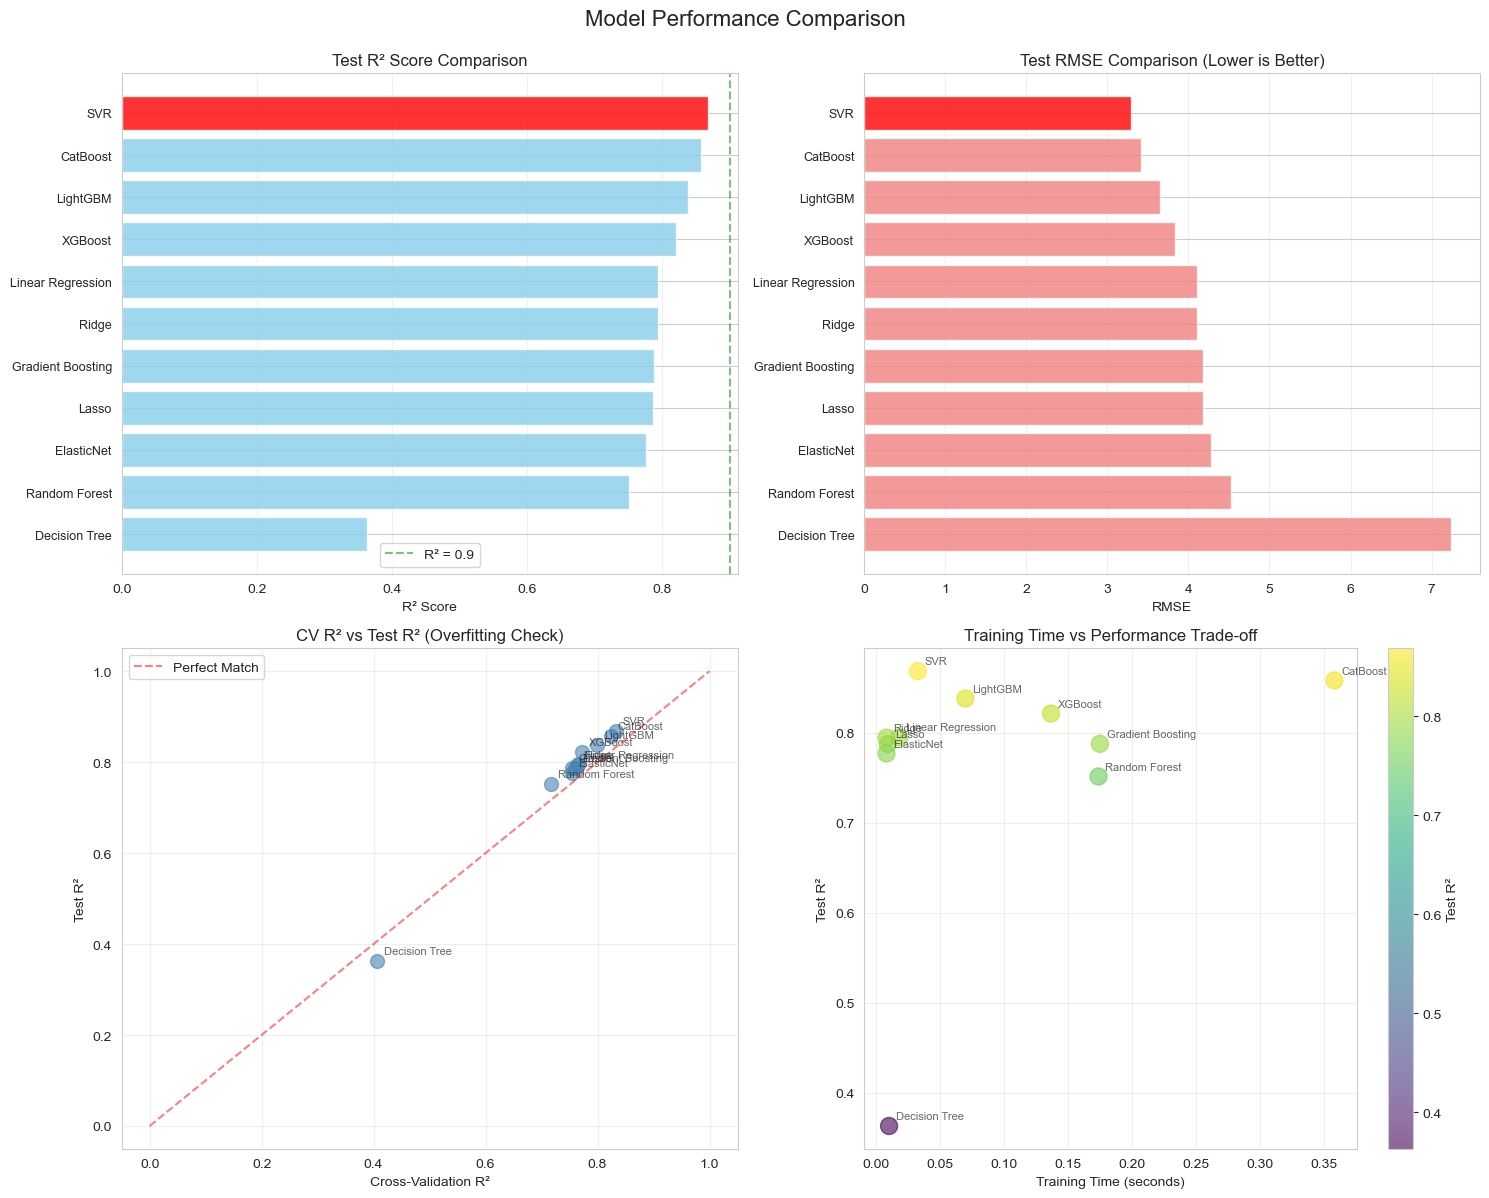

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Selection_Pipeline\figs\model_comparison.png


In [12]:
# 視覺化模型比較
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, y=0.995)

# 1. Test R² 比較
ax1 = axes[0, 0]
results_df_sorted = results_df.sort_values('Test R²', ascending=True)
colors = ['red' if x == best_model_name else 'skyblue' for x in results_df_sorted.index]
ax1.barh(range(len(results_df_sorted)), results_df_sorted['Test R²'], color=colors, alpha=0.8)
ax1.set_yticks(range(len(results_df_sorted)))
ax1.set_yticklabels(results_df_sorted.index, fontsize=9)
ax1.set_xlabel('R² Score')
ax1.set_title('Test R² Score Comparison')
ax1.axvline(x=0.9, color='green', linestyle='--', alpha=0.5, label='R² = 0.9')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# 2. Test RMSE 比較
ax2 = axes[0, 1]
results_df_sorted_rmse = results_df.sort_values('Test RMSE', ascending=False)
colors = ['red' if x == best_model_name else 'lightcoral' for x in results_df_sorted_rmse.index]
ax2.barh(range(len(results_df_sorted_rmse)), results_df_sorted_rmse['Test RMSE'], color=colors, alpha=0.8)
ax2.set_yticks(range(len(results_df_sorted_rmse)))
ax2.set_yticklabels(results_df_sorted_rmse.index, fontsize=9)
ax2.set_xlabel('RMSE')
ax2.set_title('Test RMSE Comparison (Lower is Better)')
ax2.grid(axis='x', alpha=0.3)

# 3. CV R² vs Test R² (檢查過擬合)
ax3 = axes[1, 0]
ax3.scatter(results_df['CV R² (mean)'], results_df['Test R²'], s=100, alpha=0.6, c='steelblue')
for idx in results_df.index:
    ax3.annotate(idx, (results_df.loc[idx, 'CV R² (mean)'], results_df.loc[idx, 'Test R²']), 
                 fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')
ax3.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect Match')
ax3.set_xlabel('Cross-Validation R²')
ax3.set_ylabel('Test R²')
ax3.set_title('CV R² vs Test R² (Overfitting Check)')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Training Time vs Performance
ax4 = axes[1, 1]
scatter = ax4.scatter(results_df['Training Time (s)'], results_df['Test R²'], 
                      s=150, alpha=0.6, c=results_df['Test R²'], cmap='viridis')
for idx in results_df.index:
    ax4.annotate(idx, (results_df.loc[idx, 'Training Time (s)'], results_df.loc[idx, 'Test R²']), 
                 fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')
ax4.set_xlabel('Training Time (seconds)')
ax4.set_ylabel('Test R²')
ax4.set_title('Training Time vs Performance Trade-off')
plt.colorbar(scatter, ax=ax4, label='Test R²')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存至: {FIG_DIR / 'model_comparison.png'}")

---
## 7. 最佳模型預測結果分析

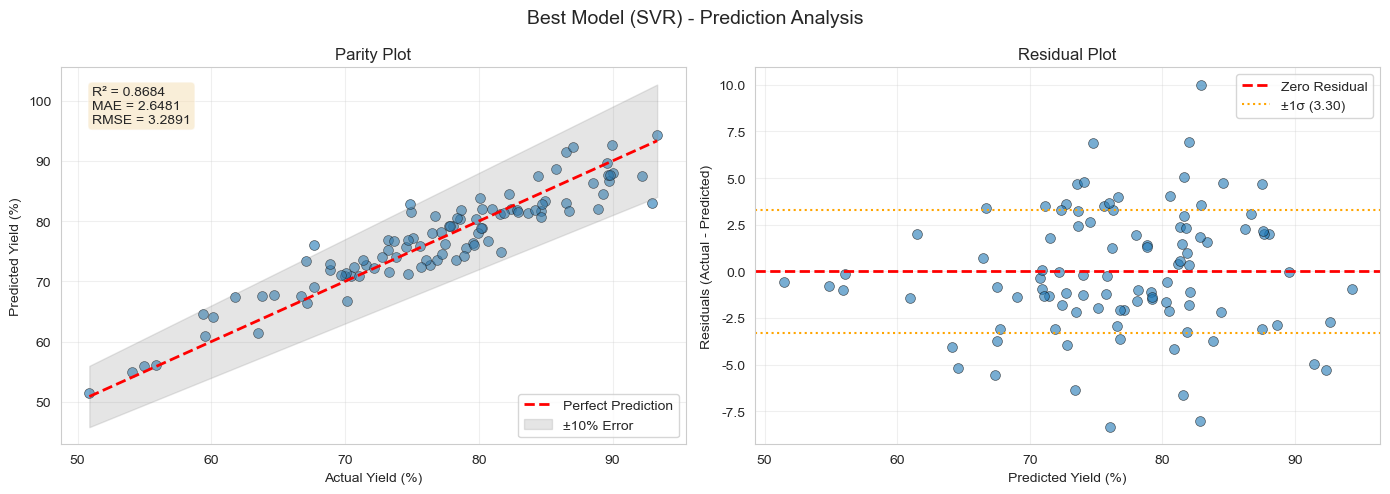

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Selection_Pipeline\figs\best_model_SVR_prediction.png


In [13]:
# 繪製最佳模型的預測結果
best_predictions = predictions[best_model_name]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'Best Model ({best_model_name}) - Prediction Analysis', fontsize=14)

# 1. Parity Plot (預測值 vs 實際值)
ax1 = axes[0]
ax1.scatter(y_test, best_predictions, alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')

# 添加 ±10% 誤差範圍
y_range = np.linspace(y_test.min(), y_test.max(), 100)
ax1.fill_between(y_range, y_range * 0.9, y_range * 1.1, alpha=0.2, color='gray', label='±10% Error')

ax1.set_xlabel('Actual Yield (%)')
ax1.set_ylabel('Predicted Yield (%)')
ax1.set_title('Parity Plot')
ax1.legend()
ax1.grid(alpha=0.3)

# 添加統計資訊
textstr = f'R² = {results_df.loc[best_model_name, "Test R²"]:.4f}\n'
textstr += f'MAE = {results_df.loc[best_model_name, "Test MAE"]:.4f}\n'
textstr += f'RMSE = {results_df.loc[best_model_name, "Test RMSE"]:.4f}'
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Residuals Plot (殘差分析)
ax2 = axes[1]
residuals = y_test - best_predictions
ax2.scatter(best_predictions, residuals, alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
ax2.axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Residual')
ax2.axhline(y=residuals.std(), color='orange', linestyle=':', lw=1.5, label=f'±1σ ({residuals.std():.2f})')
ax2.axhline(y=-residuals.std(), color='orange', linestyle=':', lw=1.5)
ax2.set_xlabel('Predicted Yield (%)')
ax2.set_ylabel('Residuals (Actual - Predicted)')
ax2.set_title('Residual Plot')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()

# 儲存圖表
fig_filename = f'best_model_{best_model_name.replace(" ", "_")}_prediction.png'
fig_path = FIG_DIR / fig_filename
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存至: {fig_path}")

---
## 8. 模型持久化 (儲存與載入)

將最佳模型與相關資訊儲存，以便後續使用與部署

In [14]:
# 儲存最佳模型 Pipeline
best_pipeline = pipelines[best_model_name]

# 重新訓練最佳模型 (使用完整訓練集)
best_pipeline.fit(X_train, y_train)

# 儲存模型
model_path = MODEL_DIR / f'best_model_{best_model_name.replace(" ", "_")}.pkl'
joblib.dump(best_pipeline, model_path)
print(f"✓ 最佳模型已儲存至: {model_path}")

# 儲存模型元資訊
model_metadata = {
    'model_name': best_model_name,
    'model_type': type(best_pipeline.named_steps['regressor']).__name__,
    'training_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'performance_metrics': {
        'test_r2': float(results_df.loc[best_model_name, 'Test R²']),
        'test_mae': float(results_df.loc[best_model_name, 'Test MAE']),
        'test_rmse': float(results_df.loc[best_model_name, 'Test RMSE']),
        'test_mape': float(results_df.loc[best_model_name, 'Test MAPE']),
        'cv_r2_mean': float(results_df.loc[best_model_name, 'CV R² (mean)']),
        'cv_r2_std': float(results_df.loc[best_model_name, 'CV R² (std)'])
    },
    'training_info': {
        'training_samples': int(X_train.shape[0]),
        'test_samples': int(X_test.shape[0]),
        'training_time_seconds': float(results_df.loc[best_model_name, 'Training Time (s)']),
        'random_seed': SEED
    },
    'features': {
        'numerical_features': numerical_features,
        'categorical_features': categorical_features,
        'total_features': len(numerical_features) + len(categorical_features)
    }
}

metadata_path = MODEL_DIR / f'best_model_metadata.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(model_metadata, f, indent=4, ensure_ascii=False)
print(f"✓ 模型元資訊已儲存至: {metadata_path}")

# 儲存特徵名稱 (用於後續預測)
feature_names = numerical_features + categorical_features
feature_info = {
    'feature_names': feature_names,
    'numerical_features': numerical_features,
    'categorical_features': categorical_features
}
feature_path = MODEL_DIR / 'feature_names.json'
with open(feature_path, 'w', encoding='utf-8') as f:
    json.dump(feature_info, f, indent=4, ensure_ascii=False)
print(f"✓ 特徵資訊已儲存至: {feature_path}")

✓ 最佳模型已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Selection_Pipeline\models\best_model_SVR.pkl
✓ 模型元資訊已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Selection_Pipeline\models\best_model_metadata.json
✓ 特徵資訊已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Selection_Pipeline\models\feature_names.json


---
## 9. 模型載入與驗證

示範如何載入已儲存的模型並進行預測

In [15]:
# 載入已儲存的模型
loaded_pipeline = joblib.load(model_path)
print(f"✓ 模型已載入: {model_path}")

# 載入模型元資訊
with open(metadata_path, 'r', encoding='utf-8') as f:
    loaded_metadata = json.load(f)

print("\n" + "=" * 80)
print("Loaded Model Information")
print("=" * 80)
print(f"Model Name: {loaded_metadata['model_name']}")
print(f"Model Type: {loaded_metadata['model_type']}")
print(f"Training Date: {loaded_metadata['training_date']}")
print(f"\nPerformance Metrics:")
for metric, value in loaded_metadata['performance_metrics'].items():
    print(f"  {metric}: {value:.4f}")
print(f"\nTraining Info:")
for key, value in loaded_metadata['training_info'].items():
    print(f"  {key}: {value}")

# 驗證載入的模型與原模型一致
y_test_pred_original = predictions[best_model_name]
y_test_pred_loaded = loaded_pipeline.predict(X_test)

# 比較預測結果
difference = np.abs(y_test_pred_original - y_test_pred_loaded).max()
print("\n" + "=" * 80)
print("Model Validation")
print("=" * 80)
print(f"✓ 載入模型與原模型預測結果一致")
print(f"  最大差異: {difference:.10f} (應接近 0)")

✓ 模型已載入: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Selection_Pipeline\models\best_model_SVR.pkl

Loaded Model Information
Model Name: SVR
Model Type: SVR
Training Date: 2026-01-22 12:55:59

Performance Metrics:
  test_r2: 0.8684
  test_mae: 2.6481
  test_rmse: 3.2891
  test_mape: 0.0345
  cv_r2_mean: 0.8326
  cv_r2_std: 0.0126

Training Info:
  training_samples: 400
  test_samples: 100
  training_time_seconds: 0.032539
  random_seed: 42

Model Validation
✓ 載入模型與原模型預測結果一致
  最大差異: 0.0000000000 (應接近 0)


---
## 10. 使用載入的模型進行新數據預測

示範實際應用場景：使用已訓練的模型預測新的反應器操作條件

In [16]:
# 建立新的操作條件數據（3個案例）
new_data = pd.DataFrame({
    'Temperature': [180, 220, 200],
    'Pressure': [5.0, 7.5, 6.0],
    'Flow_Rate': [50, 70, 60],
    'Concentration': [2.5, 3.5, 3.0],
    'Residence_Time': [30, 25, 28],
    'Catalyst_Type': ['Type_A', 'Type_B', 'Type_C'],
    'Operation_Mode': ['Continuous', 'Batch', 'Semi-Batch']
})

print("=" * 80)
print("New Operating Conditions for Prediction")
print("=" * 80)
print(new_data)

# 使用載入的模型進行預測
predictions_new = loaded_pipeline.predict(new_data)

# 顯示預測結果
print("\n" + "=" * 80)
print("Prediction Results")
print("=" * 80)
for i, pred in enumerate(predictions_new, 1):
    print(f"Case {i}: Predicted Yield = {pred:.2f}%")
    
# 建立預測結果表
new_data['Predicted_Yield'] = predictions_new
print("\n" + "=" * 80)
print("Complete Prediction Table")
print("=" * 80)
print(new_data)

# 儲存預測結果
prediction_output_path = OUTPUT_DIR / 'new_predictions.csv'
new_data.to_csv(prediction_output_path, index=False)
print(f"\n✓ 預測結果已儲存至: {prediction_output_path}")

New Operating Conditions for Prediction
   Temperature  Pressure  Flow_Rate  Concentration  Residence_Time  \
0          180       5.0         50            2.5              30   
1          220       7.5         70            3.5              25   
2          200       6.0         60            3.0              28   

  Catalyst_Type Operation_Mode  
0        Type_A     Continuous  
1        Type_B          Batch  
2        Type_C     Semi-Batch  

Prediction Results
Case 1: Predicted Yield = 80.32%
Case 2: Predicted Yield = 89.27%
Case 3: Predicted Yield = 81.42%

Complete Prediction Table
   Temperature  Pressure  Flow_Rate  Concentration  Residence_Time  \
0          180       5.0         50            2.5              30   
1          220       7.5         70            3.5              25   
2          200       6.0         60            3.0              28   

  Catalyst_Type Operation_Mode  Predicted_Yield  
0        Type_A     Continuous        80.322518  
1        Type_B     

---
## 11. Pipeline 應用指南

### Pipeline 優勢

1. **自動化前處理**：Pipeline 自動處理數值標準化與類別編碼
2. **避免資料洩漏**：確保前處理只在訓練集上學習，測試集僅轉換
3. **簡化部署**：單一物件包含所有處理步驟，易於儲存與載入
4. **可重複性**：確保相同的資料處理流程

### 使用載入模型的完整流程

```python
# 1. 載入模型與元資訊
import joblib
import json

model = joblib.load('best_model_XXX.pkl')
with open('best_model_metadata.json', 'r') as f:
    metadata = json.load(f)

# 2. 準備新數據（必須包含所有訓練特徵）
new_data = pd.DataFrame({
    'Temperature': [200],
    'Pressure': [6.0],
    'Flow_Rate': [60],
    'Concentration': [3.0],
    'Residence_Time': [28],
    'Catalyst_Type': ['Type_A'],
    'Operation_Mode': ['Continuous']
})

# 3. 預測（Pipeline 自動處理前處理）
predictions = model.predict(new_data)
print(f"Predicted Yield: {predictions[0]:.2f}%")
```

### 注意事項

- 新數據必須包含所有訓練時使用的特徵
- 類別特徵的值必須在訓練集中出現過
- 數值特徵的範圍建議在訓練集範圍內，避免外推

---
## 12. 總結

### 本 Notebook 學習重點

1. **資料前處理 Pipeline**
   - 使用 `ColumnTransformer` 整合不同類型特徵的前處理
   - 數值特徵標準化 (StandardScaler)
   - 類別特徵編碼 (OneHotEncoder)

2. **完整建模 Pipeline**
   - 使用 `Pipeline` 整合前處理與模型訓練
   - 避免資料洩漏問題
   - 簡化模型部署流程

3. **多模型自動化評估**
   - 建立模型字典，批次訓練與評估
   - 使用交叉驗證評估模型穩健性
   - 綜合多項指標選擇最佳模型

4. **模型持久化**
   - 使用 `joblib` 儲存完整 Pipeline
   - 儲存模型元資訊 (JSON)
   - 載入模型進行新數據預測

5. **化工應用實務**
   - 反應器程序品質預測系統
   - 考慮多種操作變數與類別特徵
   - 建立可部署的預測模型

### 關鍵程式碼範本

```python
# Pipeline 建立
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# 訓練與評估
pipeline.fit(X_train, y_train)
score = pipeline.score(X_test, y_test)

# 儲存與載入
joblib.dump(pipeline, 'model.pkl')
loaded_model = joblib.load('model.pkl')
```

### 下一步學習方向

- 超參數調整 (Grid Search, Bayesian Optimization)
- 模型解釋性分析 (Feature Importance, SHAP)
- 進階集成學習方法 (Stacking, Blending)
- 模型監控與更新策略

---

**課程完成！**